### Bibliotecas necessárias

In [9]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.applications import ResNet50
%matplotlib inline
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras import regularizers


In [10]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Matplotlib version:", matplotlib.__version__)

TensorFlow version: 2.16.1
Keras version: 3.3.3
Matplotlib version: 3.9.0


### Dataset

In [16]:
# mostrar a quantidade de imagens e classes de treinamento 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    
    "../data/train",
    
    image_size=(180, 180),  # Definir o tamanho das imagens
    
    batch_size=16 # quantidade de imagens por lote 

)

Found 3391 files belonging to 6 classes.


In [17]:
# mostrar o nome das classes
nomes_classes = dataset.class_names
nomes_classes

['Apple', 'Banana', 'Grape', 'Mango', 'Orange', 'Strawberry']

In [18]:
# Contar a quantidade de imagens por classe
class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Exibir a quantidade de imagens por classe
for class_name, count in class_counts.items():
    print(f'A classe {class_name} tem {count} imagens')

# Exibir a quantidade total de classes
num_classes = len(dataset.class_names)
print(f'Total de classes: {num_classes}')

# Exibir a quantidade total de imagens
total_images = sum(class_counts.values())
print(f'Total de imagens: {total_images}')

# Exibir a porcentagem de imagens por classe
for class_name, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f'A classe {class_name} tem {percentage:.2f}% das imagens')

A classe Apple tem 552 imagens
A classe Banana tem 601 imagens
A classe Grape tem 517 imagens
A classe Mango tem 633 imagens
A classe Orange tem 460 imagens
A classe Strawberry tem 628 imagens
Total de classes: 6
Total de imagens: 3391
A classe Apple tem 16.28% das imagens
A classe Banana tem 17.72% das imagens
A classe Grape tem 15.25% das imagens
A classe Mango tem 18.67% das imagens
A classe Orange tem 13.57% das imagens
A classe Strawberry tem 18.52% das imagens


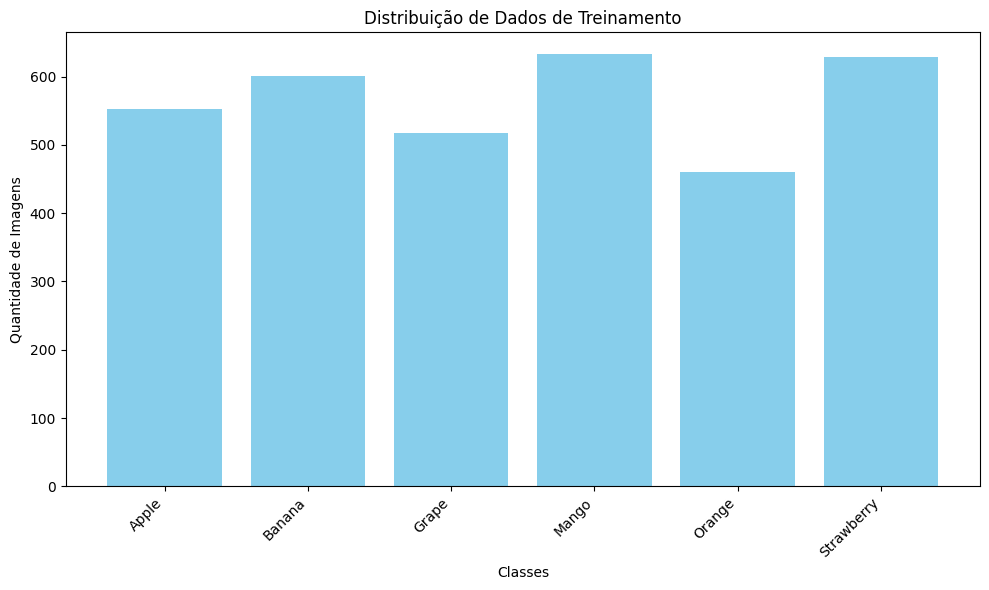

In [19]:
import matplotlib.pyplot as plt

# Exemplo dos dados coletados
class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Dados para plotagem
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plotando o histograma
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Quantidade de Imagens')
plt.title('Distribuição de Dados de Treinamento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


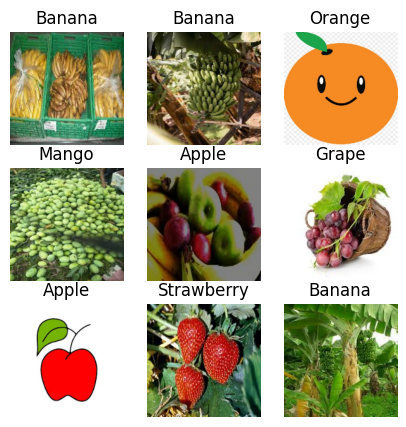

In [20]:
plt.figure(figsize=(5, 5))

for images, labels in dataset.take(1):  # Pegar um lote de imagens
    
    for i in range(9):  # Mostrar as primeiras 9 imagens
        
        ax = plt.subplot(3, 3, i + 1) # exibição das imagens 3X3
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(nomes_classes[labels[i]]) # para mostrar o nome da classe
        
        plt.axis("off")
        
plt.show()

In [21]:
# Definindo image_size e batch_size
image_size = (180, 180)
batch_size = 16

# Caminhos para os dados de treinamento e validação
treinamento_data = "../data/train"
validaca_data = "../data/valid"
teste_data ='../data/test'

X_test = validaca_data
X_train = treinamento_data

# Carregando os datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    validaca_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    teste_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 3391 files belonging to 6 classes.
Found 226 files belonging to 6 classes.
Found 157 files belonging to 6 classes.


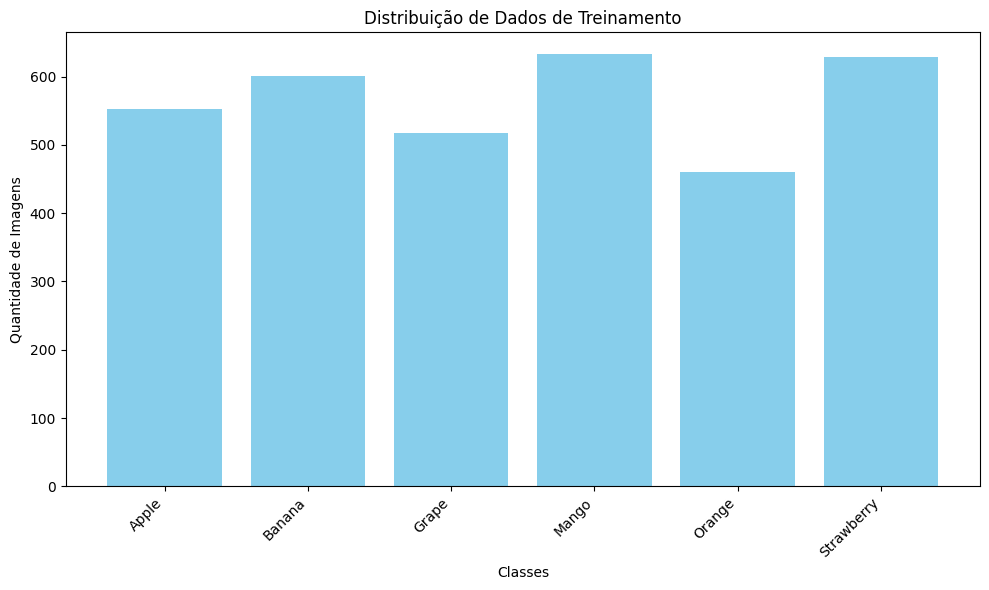

In [22]:
import matplotlib.pyplot as plt

# Exemplo dos dados coletados
class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Dados para plotagem
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plotando o histograma
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Quantidade de Imagens')
plt.title('Distribuição de Dados de Treinamento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [32]:

import tensorflow as tf

# Normalização dos dados usando TensorFlow
train_data = train_data.map(lambda x, y: (tf.image.per_image_standardization(x), y))
val_data = val_data.map(lambda x, y: (tf.image.per_image_standardization(x), y))
test_data = test_data.map(lambda x, y: (tf.image.per_image_standardization(x), y))



### Data augmentation

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurar o ImageDataGenerator com transformações de aumento de dados
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [65]:
# Diretório das imagens organizadas em subdiretórios de classes
train_dir = '../data'

# Criar um gerador de dados de treinamento
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),  # Defina o tamanho desejado das imagens
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' se os rótulos forem inteiros
)

Found 3774 images belonging to 3 classes.


## aplicando modelo de rede neural

In [24]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.regularizers import l2

# Definindo o modelo
modelo2 = models.Sequential()

# Adicionando camadas com regularização L2
modelo2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3), kernel_regularizer=regularizers.l2(0.01)))
modelo2.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) 

modelo2.add(layers.Conv2D(64,(3,3), activation='relu', kernel_regularizer=l2(0.01)))
modelo2.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) 


# Flatten antes da camada densa
modelo2.add(layers.Flatten())
modelo2.add(layers.Dropout(0.25))

# Camada densa com regularização L2
modelo2.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# Compilando o modelo
modelo2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


In [25]:
import tensorflow as tf

# Data augmentation - usada para diminuir o overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])


In [26]:
history = modelo2.fit(
    train_data,
    epochs=20,
    validation_data = val_data,
)

Epoch 1/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.2353 - loss: 184.8799 - val_accuracy: 0.2965 - val_loss: 2.6410
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 37s 174ms/step - accuracy: 0.3337 - loss: 2.6918 - val_accuracy: 0.3186 - val_loss: 2.6463
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.4669 - loss: 2.3558 - val_accuracy: 0.3053 - val_loss: 2.6721
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.5295 - loss: 2.1869 - val_accuracy: 0.3274 - val_loss: 2.9800
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.5844 - loss: 2.1010 - val_accuracy: 0.2965 - val_loss: 3.1180
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.6027 - loss: 2.0450 - val_accuracy: 0.3097 - val_loss: 3.3359
Epoch 7/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.6640 - loss: 1.8528 - val_accuracy: 0.2832 - val_loss: 3.7917
Epoch 8/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - accuracy: 0.7118 - loss:

In [27]:


with open('../models/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [28]:
import os

file_path = '../models/history.pkl'
if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
    print(history)
else:
    print("Erro: o arquivo está vazio.")


{'accuracy': [0.25626659393310547, 0.364494264125824, 0.480389267206192, 0.5552934408187866, 0.6083751320838928, 0.6207608580589294, 0.6820996999740601, 0.694190502166748, 0.7042170166969299, 0.7661457061767578, 0.7693895697593689, 0.7847242951393127, 0.7767620086669922, 0.810675323009491, 0.8254202008247375, 0.8153936862945557, 0.8189324736595154, 0.8437039256095886, 0.839870274066925, 0.8392804265022278], 'loss': [46.35358428955078, 2.649643659591675, 2.3330750465393066, 2.130943536758423, 2.06792950630188, 2.004509687423706, 1.849503517150879, 1.894323706626892, 1.8840112686157227, 1.6306464672088623, 1.6348353624343872, 1.706247329711914, 1.6468560695648193, 1.5325026512145996, 1.4847711324691772, 1.558398962020874, 1.5482192039489746, 1.4692198038101196, 1.5325366258621216, 1.5576789379119873], 'val_accuracy': [0.29646018147468567, 0.3185840845108032, 0.3053097426891327, 0.32743361592292786, 0.29646018147468567, 0.3097345232963562, 0.28318583965301514, 0.3362831771373749, 0.393805

In [29]:

modelo2.save('../models/modelo2.h5')

In [30]:
from tensorflow.keras.models import load_model

modelo2 = load_model('C:/Users/brena/OneDrive/Documentos/github/Frutas-ML/models/modelo2.h5')

In [1]:
# mostrar o historico de treinamento

accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training e Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and ValidationLoss')

plt.show()

NameError: name 'history' is not defined

In [73]:
# avaliar o modelo

train_loss, train_acc = modelo2.evaluate(train_data, verbose=2)

print('\nTraining accuracy:', train_acc)

print('\nTraining loss:', train_loss)

106/106 - 14s - 136ms/step - accuracy: 0.9690 - loss: 1.2061

Training accuracy: 0.9690356850624084

Training loss: 1.2061198949813843


In [42]:
# Avaliando o modelo no conjunto de validação
val_loss, val_accuracy = modelo2.evaluate(val_data)
print(f'Validação - Perda: {val_loss}, Acurácia: {val_accuracy}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4940 - loss: 2.7830
Validação - Perda: 2.5410804748535156, Acurácia: 0.5442478060722351


In [45]:
# Avaliando o modelo no conjunto de teste
val_loss, val_acc = modelo2.evaluate(val_data, verbose=2)

print('\nTest accuracy:', val_acc)
print('\nTest loss:', val_loss)


8/8 - 1s - 84ms/step - accuracy: 0.5442 - loss: 2.5411

Test accuracy: 0.5442478060722351

Test loss: 2.5410804748535156


In [1]:
# Carregando o conjunto de dados de validação
validacao_data = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/valid",
    label_mode='int',
    batch_size=32,
    image_size=(180, 180),
    shuffle=False
)

NameError: name 'tf' is not defined

### Matriz de confusão

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


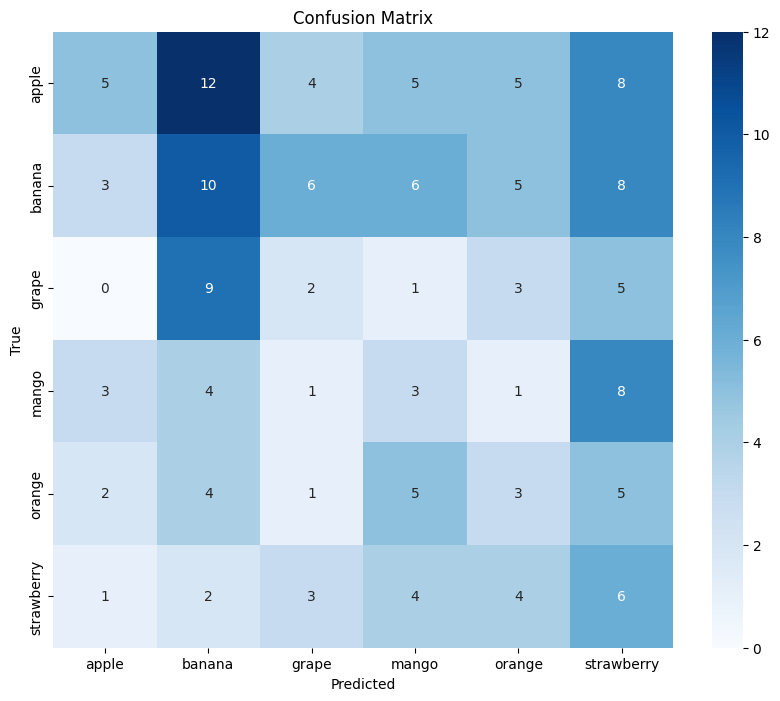

Classification Report:
              precision    recall  f1-score   support

       apple       0.36      0.13      0.19        39
      banana       0.24      0.26      0.25        38
       grape       0.12      0.10      0.11        20
       mango       0.12      0.15      0.14        20
      orange       0.14      0.15      0.15        20
  strawberry       0.15      0.30      0.20        20

    accuracy                           0.18       157
   macro avg       0.19      0.18      0.17       157
weighted avg       0.22      0.18      0.18       157



In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Definindo manualmente os nomes das classes (substitua com suas classes reais)
class_names = ['apple', 'banana', 'grape', 'mango', 'orange', 'strawberry']

# Fazendo previsões no conjunto de teste
y_pred = modelo2.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtendo os rótulos reais do conjunto de teste
y_true = np.concatenate([y for _, y in test_data], axis=0)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


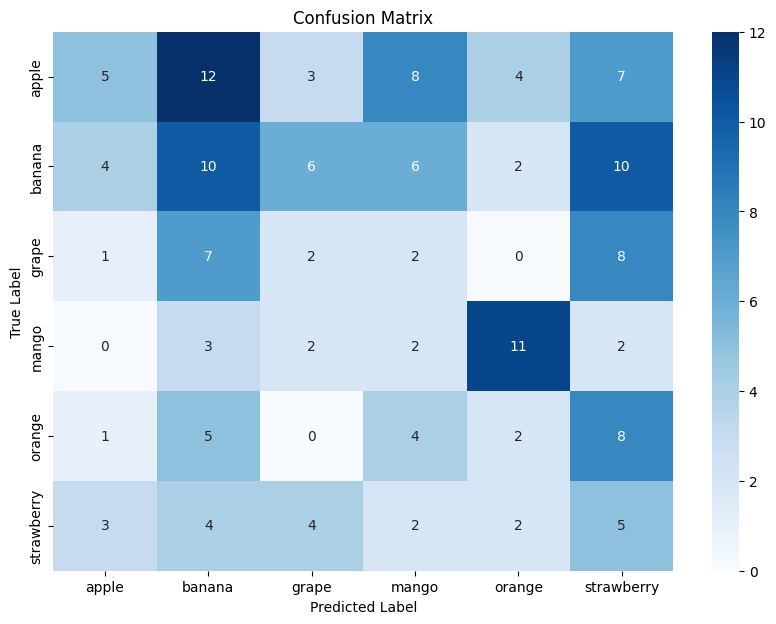

Classification Report:
              precision    recall  f1-score   support

       apple       0.36      0.13      0.19        39
      banana       0.24      0.26      0.25        38
       grape       0.12      0.10      0.11        20
       mango       0.08      0.10      0.09        20
      orange       0.10      0.10      0.10        20
  strawberry       0.12      0.25      0.17        20

    accuracy                           0.17       157
   macro avg       0.17      0.16      0.15       157
weighted avg       0.20      0.17      0.17       157



In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Definindo manualmente os nomes das classes
class_names = ['apple', 'banana', 'grape', 'mango', 'orange', 'strawberry']

# Fazendo previsões no conjunto de teste
y_pred = modelo2.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)


# Calculando a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizando a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)


In [53]:
# Verificar o tamanho de y_true e y_pred_classes
print("Tamanho de y_true:", len(y_true))
print("Tamanho de y_pred_classes:", len(y_pred_classes))


Tamanho de y_true: 157
Tamanho de y_pred_classes: 157
